In [33]:
import yaml
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.spectrum import SpectrumFit
from gammapy.spectrum.models import SpectralModel

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
files ={ 
    'fact':'results/fit/gammapy/fact/fit_results_logparabola.yaml',
    'magic':'results/fit/gammapy/magic/fit_results_logparabola.yaml',
    'fermi':'results/fit/gammapy/fermi/fit_results_logparabola.yaml',
    'hess':'results/fit/gammapy/hess/fit_results_logparabola.yaml',
    'veritas':'results/fit/gammapy/veritas/fit_results_logparabola.yaml',
    'joint':'results/fit/gammapy/joint/fit_results_logparabola.yaml',
}
tels = ['fact', 'magic', 'fermi', 'hess', 'veritas']


def load_mu_sigma(name):
    path = files[name]
    f = open(path)
    r = yaml.load(f)
    mu = r['parameters'][3]['value']
    sigma = r['parameters'][3]['error']
    return mu, sigma
    

In [35]:
results = {}
for tel in tels:
    mu, sigma = load_mu_sigma(tel)
    results[tel] =  {}
    results[tel]['mu'] = mu
    results[tel]['sigma'] = sigma
results = pd.DataFrame(results)

results

,fact,fermi,hess,magic,veritas
mu,0.416083,0.160184,0.391538,0.428723,0.298520
sigma,0.311628,0.121872,0.226925,0.111111,0.178265


I plot the single fit results for the $\beta$ parameter including the estimated standard deviations from the output in the yaml files. This looks just like on would expect and totally fits the countour plots in the paper.


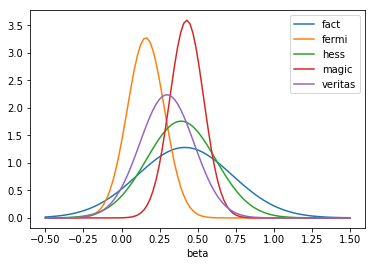

In [36]:
for tel in results.columns:
    mu = results[tel].mu
    sigma = results[tel].sigma
    x = np.linspace(-0.5, 1.5, 100)
    plt.plot(x, norm.pdf(x, scale=sigma, loc=mu), label=tel)

plt.legend()
plt.xlabel('beta')
None

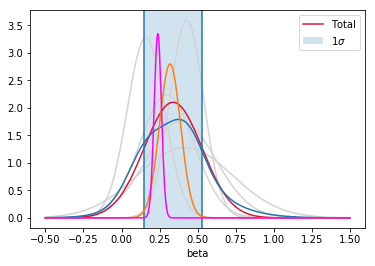

In [37]:
x = np.linspace(-0.5, 1.5, 500)
ps = []
for tel in results.columns:
    mu = results[tel].mu
    sigma = results[tel].sigma
    pdf = norm.pdf(x, scale=sigma, loc=mu)
    plt.plot(x, pdf , color='lightgray')
    ps.append(pdf)

N = len(results.T)
mu_total = results.T.sum().mu / N
sigma_total = results.T.sum().sigma / N
plt.plot(x, norm.pdf(x, scale=sigma_total, loc=mu_total), color='crimson', label='Total')

plt.axvline(mu_total - sigma_total)
plt.axvline(mu_total + sigma_total)

plt.axvspan(mu_total - sigma_total, mu_total + sigma_total, alpha=0.2, label='$1 \sigma$')
plt.legend()
plt.xlabel('beta')



plt.plot(x, np.array(ps).sum(axis=0)/N)
plt.plot(x, np.array(ps).prod(axis=0)/N)

mu_joint, sigma_joint = load_mu_sigma('joint')
plt.plot(x, norm.pdf(x, scale=sigma_joint, loc=mu_joint)/N, color='magenta', label='joint')

None

In [169]:
from joint_crab.conf import config
from joint_crab.models import Log10Parabola
dataset = config.get_dataset('magic')
obs_list = dataset.get_SpectrumObservationList()
fit_range = dataset.energy_range


In [170]:
model_lp = Log10Parabola(
    amplitude=3.8 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.3 * u.Unit(''),
    beta=0.2 * u.Unit(''),
)
fit = SpectrumFit(obs_list=obs_list, model=model_lp, fit_range=fit_range)
fit.optimize()
result = fit.result[1]
min_statval = result.statval
# min_statval, fit._statval, fit._statval[1].sum()

In [171]:
result.model.parameters

In [172]:
N = 30
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

In [173]:
# model_lp = Log10Parabola(
#     amplitude=3.8 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
#     reference=1 * u.Unit('TeV'),
#     alpha=2.3 * u.Unit(''),
#     beta=0.2 * u.Unit(''),
# )
# fit = SpectrumFit(obs_list=obs_list, model=model_lp, fit_range=fit_range)
# fit.optimize()
# result = fit.result[0]

# best_fit_amplitude = result.model.parameters.parameters[0].value

# zs = []
# for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
#     model_lp = Log10Parabola(
#         amplitude=best_fit_amplitude * u.Unit('cm-2 s-1 TeV-1'),
#         reference=1 * u.Unit('TeV'),
#         alpha=alpha * u.Unit(''),
#         beta=beta * u.Unit(''),
#     )
#     model_lp.parameters[2].frozen=True
#     model_lp.parameters[3].frozen=True
#     fit = SpectrumFit(obs_list=obs_list, model=model_lp, fit_range=fit_range)
#     fit.optimize()
#     result = fit.total_stat(fit.result[0].model.parameters)
#     zs.append(result)

# zs = np.array(zs)
# normalization = zs

In [174]:
zs = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    model_lp = Log10Parabola(
        amplitude=best_fit_amplitude * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    fit = SpectrumFit(obs_list=obs_list, model=model_lp, fit_range=fit_range)
    zs.append(fit.total_stat(model_lp.parameters))

zs = np.array(zs)
lh_ratio = zs - zs.min()


900it [00:07, 123.85it/s]


Text(0,0.5,'beta')

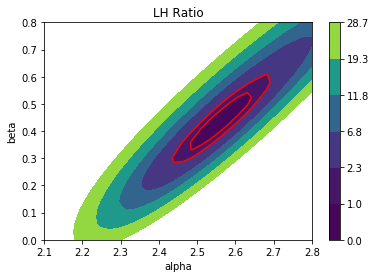

In [175]:
plt.title('LH Ratio')
plt.contourf(a, b, lh_ratio.reshape(len(a), -1), levels=[0, 1, 2.3 , 6.8, 11.8, 19.3, 28.7], )
plt.colorbar()
plt.contour(a, b, lh_ratio.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
plt.xlabel('alpha')
plt.ylabel('beta')


In [176]:
from scipy.stats import chi2
chi2.ppf(0.999936657516334, df=2)
chi2.ppf(0.999999426696856, df=2)

28.74370242616088